# Data Exploration Notebook

In [1]:
# Listing 1 — Setup
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import networkx as nx

# --- Paths: edit these to your project layout ---
PATH_MEMBERSHIP = Path("data/processed/universe_membership_wiki_sp400.csv")
PATH_PRICES_MERGED = Path("data/merged/prices.parquet")
PATH_VOLUME_MERGED = Path("data/merged/volume.parquet")

# Optional (only if you saved pre-augmentation panels / provenance)
PATH_PRICES_STOOQ = Path("data/stooq/prices.parquet")
OUTDIR = Path("figs_data_collection")
OUTDIR.mkdir(parents=True, exist_ok=True)


In [2]:
# Listing 2 — Load
mem = pd.read_csv(PATH_MEMBERSHIP, parse_dates=["start","end"])
prices = pd.read_parquet(PATH_PRICES_MERGED)
volume = pd.read_parquet(PATH_VOLUME_MERGED)

# Ensure index types
prices.index = pd.to_datetime(prices.index)
volume.index = pd.to_datetime(volume.index)

print("Membership rows:", len(mem))
print("Merged prices shape (dates x tickers):", prices.shape)
print("Merged volume shape (dates x tickers):", volume.shape)
print("Dates span:", prices.index.min().date(), "→", prices.index.max().date())
print("Tickers (merged) :", prices.columns.nunique())


Membership rows: 752
Merged prices shape (dates x tickers): (3774, 853)
Merged volume shape (dates x tickers): (3774, 853)
Dates span: 2010-01-04 → 2024-12-31
Tickers (merged) : 853


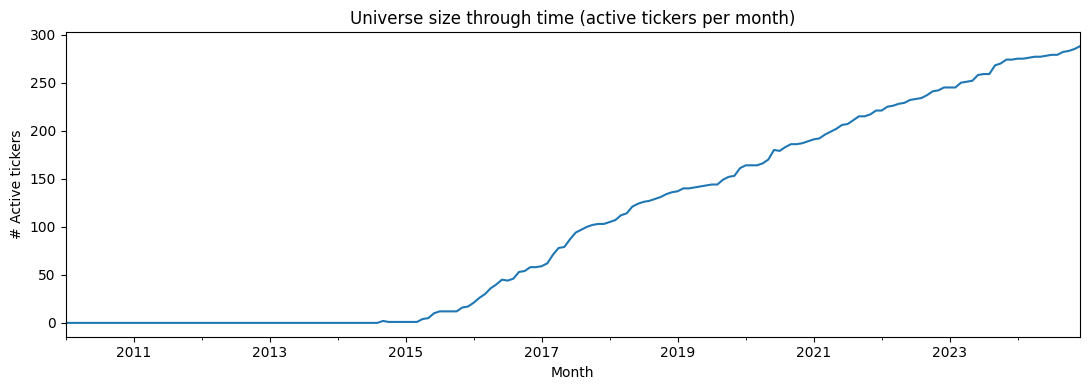

In [3]:
mem2 = mem.copy()
mem2["end"] = mem2["end"].fillna(prices.index.max())
cal_m = pd.date_range(prices.index.min(), prices.index.max(), freq="ME")

def active_count(ts):
    return ((mem2["start"] <= ts) & (mem2["end"] >= ts)).sum()

active_series = pd.Series({ts: active_count(ts) for ts in cal_m}).sort_index()

plt.figure(figsize=(11,4))
active_series.plot()
plt.title("Universe size through time (active tickers per month)")
plt.xlabel("Month"); plt.ylabel("# Active tickers")
plt.tight_layout(); plt.savefig(OUTDIR/"fig_universe_size.png", dpi=160); plt.show()


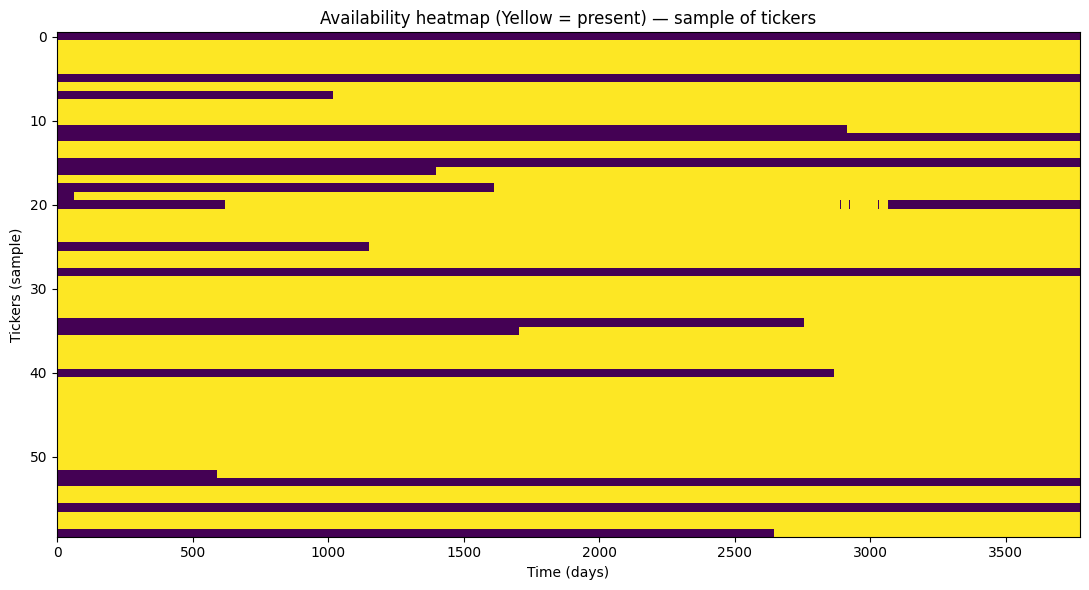

In [4]:
np.random.seed(7)
sample_n = min(60, prices.shape[1])
cols = np.random.choice(prices.columns, size=sample_n, replace=False)
avail = (~prices[cols].isna()).astype(int)

plt.figure(figsize=(11,6))
plt.imshow(avail.T, aspect="auto", interpolation="nearest")
plt.title("Availability heatmap (Yellow = present) — sample of tickers")
plt.xlabel("Time (days)")
plt.ylabel("Tickers (sample)")
plt.tight_layout()
plt.savefig(OUTDIR/"fig_availability_heatmap.png", dpi=160)
plt.show()


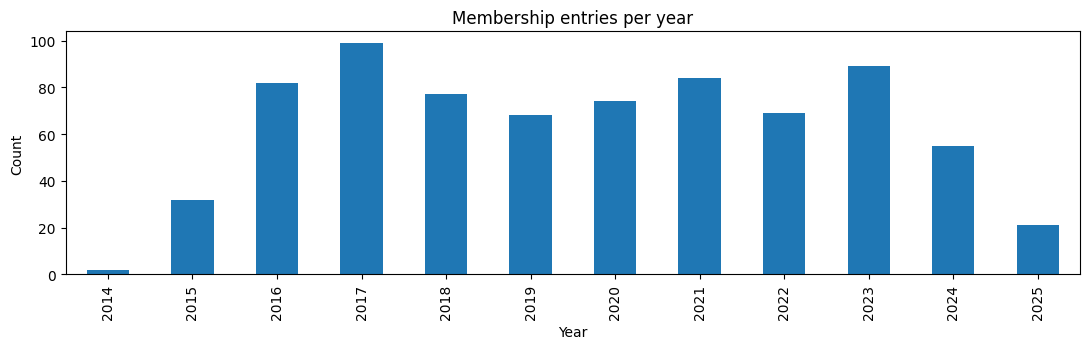

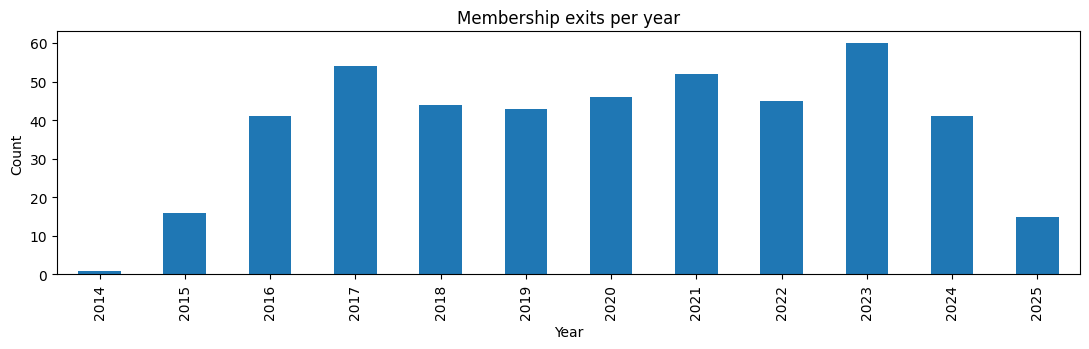

In [5]:
entries = mem["start"].dt.to_period("Y").value_counts().sort_index()
exits   = mem["end"].dropna().dt.to_period("Y").value_counts().sort_index()
years = sorted(set(entries.index.astype(str)) | set(exits.index.astype(str)))

entries = entries.reindex(years).fillna(0).astype(int)
exits   = exits.reindex(years).fillna(0).astype(int)

plt.figure(figsize=(11,3.6))
entries.index = entries.index.astype(str); entries.plot(kind="bar")
plt.title("Membership entries per year"); plt.xlabel("Year"); plt.ylabel("Count")
plt.tight_layout(); plt.savefig(OUTDIR/"fig_entries_per_year.png", dpi=160); plt.show()

plt.figure(figsize=(11,3.6))
exits.index = exits.index.astype(str)
exits.plot(kind="bar")
plt.title("Membership exits per year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(OUTDIR/"fig_exits_per_year.png", dpi=160)
plt.show()


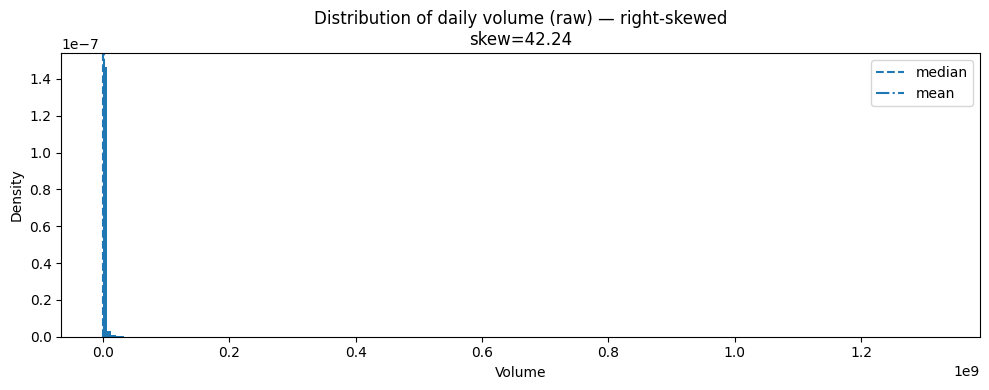

In [6]:
v = volume.stack().dropna()
skew_raw = v.skew()

plt.figure(figsize=(10,4))
plt.hist(v, bins=200, density=True)
plt.title(f"Distribution of daily volume (raw) — right-skewed\nskew={skew_raw:.2f}")
plt.xlabel("Volume")
plt.ylabel("Density")
plt.axvline(v.median(), linestyle="--", label="median")
plt.axvline(v.mean(), linestyle="-.", label="mean")
plt.legend()
plt.tight_layout()
plt.savefig("figs_data_collection/fig_volume_raw.png", dpi=160)
plt.show()

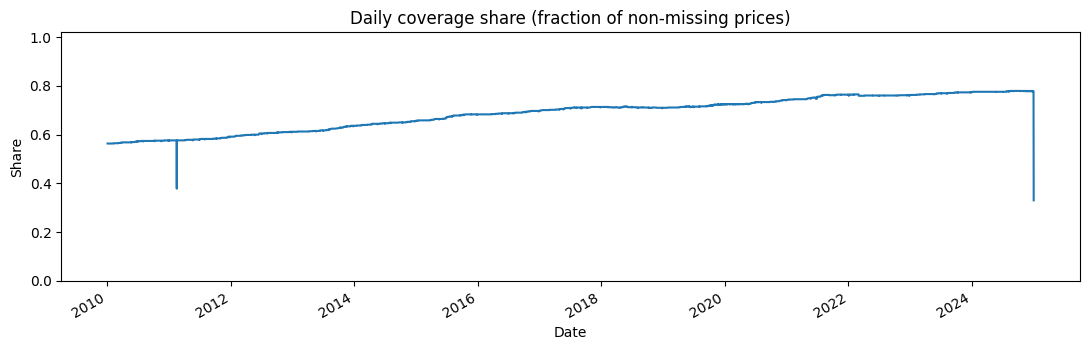

In [7]:
daily_cov = (~prices.isna()).mean(axis=1)
plt.figure(figsize=(11,3.6))
daily_cov.plot()
plt.title("Daily coverage share (fraction of non-missing prices)")
plt.xlabel("Date")
plt.ylabel("Share")
plt.ylim(0, 1.02)
plt.tight_layout()
plt.savefig(OUTDIR/"fig_daily_coverage.png", dpi=160)
plt.show()


In [8]:
# Membership validation (run once)
mem = pd.read_csv(PATH_MEMBERSHIP, parse_dates=["start","end"])
mem["end"] = mem["end"].fillna(prices.index.max())

# start <= end
bad_order = mem[mem["start"] > mem["end"]]
print("Bad intervals:", len(bad_order))

# duplicates
dupes = mem.duplicated(["ticker","start","end"]).sum()
print("Duplicate rows:", dupes)

# overlapping intervals per ticker
overlap = 0
for tkr, g in mem.sort_values(["ticker","start"]).groupby("ticker"):
    if (g["start"].shift(-1) <= g["end"]).fillna(False).any():
        overlap += 1
print("Tickers with overlaps:", overlap)

# coverage in panels after symbol normalisation
sym_in_panel = set(prices.columns)
missing_syms = set(mem["ticker"]) - sym_in_panel
print("Membership tickers not in merged panels:", len(missing_syms))


Bad intervals: 15
Duplicate rows: 0
Tickers with overlaps: 0
Membership tickers not in merged panels: 0


In [9]:
# Clean membership intervals
mem = pd.read_csv(PATH_MEMBERSHIP, parse_dates=["start","end"])
mem["end"] = mem["end"].fillna(prices.index.max())

# Flag inverted intervals
inv = mem["end"] < mem["start"]
print("Inverted intervals to review:", int(inv.sum()))

# Heuristic 1: swap if the swap yields a positive duration and <= 15 years (guard against typos)
dur = (mem["start"] - mem["end"]).abs().dt.days
swap_ok = inv & (dur <= 15*365)
mem.loc[swap_ok, ["start","end"]] = mem.loc[swap_ok, ["end","start"]].values

# Heuristic 2: drop any remaining inverted rows (can also log to a CSV for manual audit)
drop_idx = mem.index[ mem["end"] < mem["start"] ]
if len(drop_idx):
    mem.loc[drop_idx].to_csv("figs_exploration/membership_bad_intervals.csv", index=False)
    mem = mem.drop(index=drop_idx)

# Clip to the market data span
lo, hi = prices.index.min(), prices.index.max()
mem["start"] = mem["start"].clip(lower=lo, upper=hi)
mem["end"]   = mem["end"].clip(lower=lo, upper=hi)

# Re-run the checks
bad_order = (mem["start"] > mem["end"]).sum()
overlap = 0
for tkr, g in mem.sort_values(["ticker","start"]).groupby("ticker"):
    if (g["start"].shift(-1) <= g["end"]).fillna(False).any():
        overlap += 1

print("After clean → bad intervals:", bad_order, "| tickers with overlaps:", overlap)

# Save a cleaned copy for downstream steps
mem.to_csv("data/processed/universe_membership_clean.csv", index=False)


Inverted intervals to review: 15
After clean → bad intervals: 0 | tickers with overlaps: 0


In [10]:
PATH_MEMBERSHIP_CLEAN = Path("data/processed/universe_membership_clean.csv")

mem = pd.read_csv(PATH_MEMBERSHIP_CLEAN, parse_dates=["start","end"])
mem["end"] = mem["end"].fillna(prices.index.max())

bad = int((mem["start"] > mem["end"]).sum())
dups = int(mem.duplicated(["ticker","start","end"]).sum())
overlap = sum(
    (g.sort_values("start")["start"].shift(-1) <= g["end"]).fillna(False).any()
    for _, g in mem.groupby("ticker")
)
missing = len(set(mem["ticker"]) - set(prices.columns))
pd.DataFrame({"bad_intervals":[bad], "duplicates":[dups], "overlaps":[overlap], "tickers_not_in_panel":[missing]})


,bad_intervals,duplicates,overlaps,tickers_not_in_panel
0,0,0,0,0


In [11]:
sym_in_panel = set(prices.columns)
missing_syms = set(mem["ticker"]) - sym_in_panel
print("Membership tickers not in merged panels:", len(missing_syms))

Membership tickers not in merged panels: 0


{'is_datetimeindex': True, 'is_monotonic_increasing': True, 'num_duplicate_dates': 0}


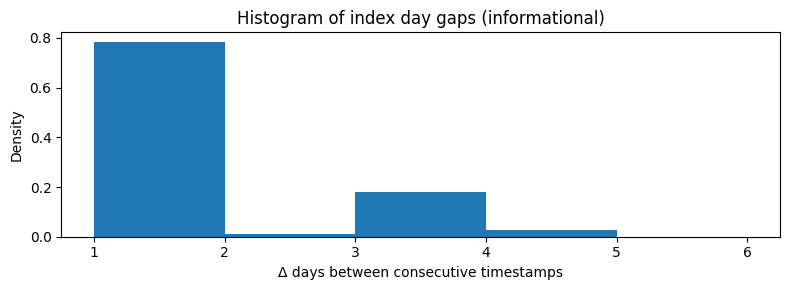

In [12]:
idx = prices.index
qa_a = {
    "is_datetimeindex": isinstance(idx, pd.DatetimeIndex),
    "is_monotonic_increasing": idx.is_monotonic_increasing,
    "num_duplicate_dates": int(pd.Index(idx).duplicated().sum()),
}

print(qa_a)

# show distribution of day gaps
gaps = pd.Series(idx).diff().dt.days.dropna()
plt.figure(figsize=(8,3))
plt.hist(gaps, bins=range(int(gaps.min()), int(gaps.max())+2), density=True)
plt.title("Histogram of index day gaps (informational)")
plt.xlabel("Δ days between consecutive timestamps"); plt.ylabel("Density")
plt.tight_layout(); plt.savefig(OUTDIR/"fig_index_day_gaps.png", dpi=160); plt.show()

# Hard assertions for the record (will raise if violated)
assert qa_a["is_datetimeindex"], "Index is not a DatetimeIndex."
assert qa_a["is_monotonic_increasing"], "Index is not sorted ascending."
assert qa_a["num_duplicate_dates"] == 0, "Duplicate dates present."

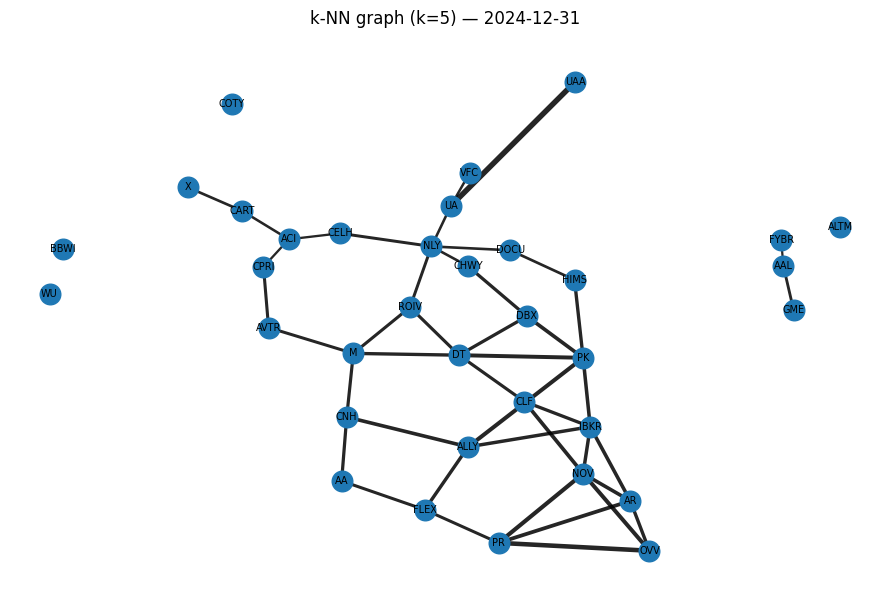

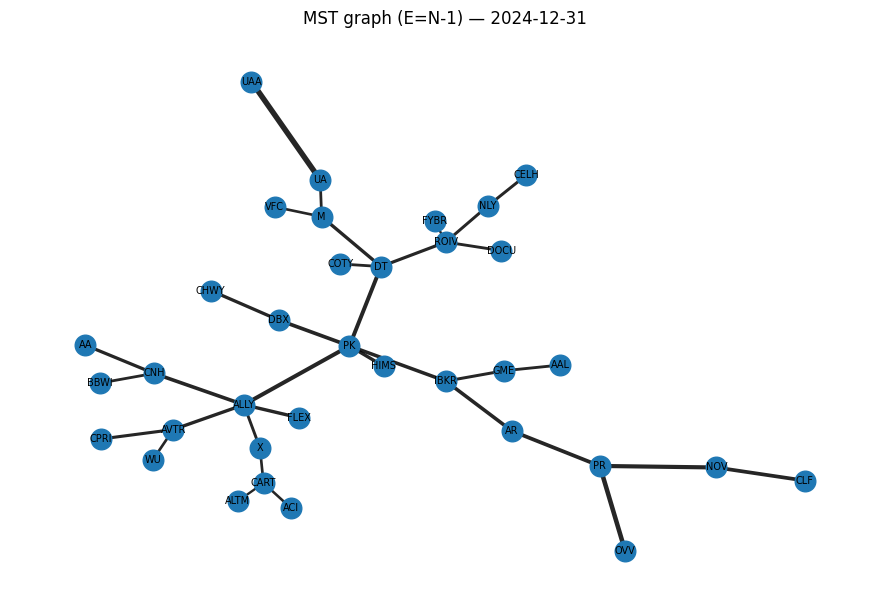

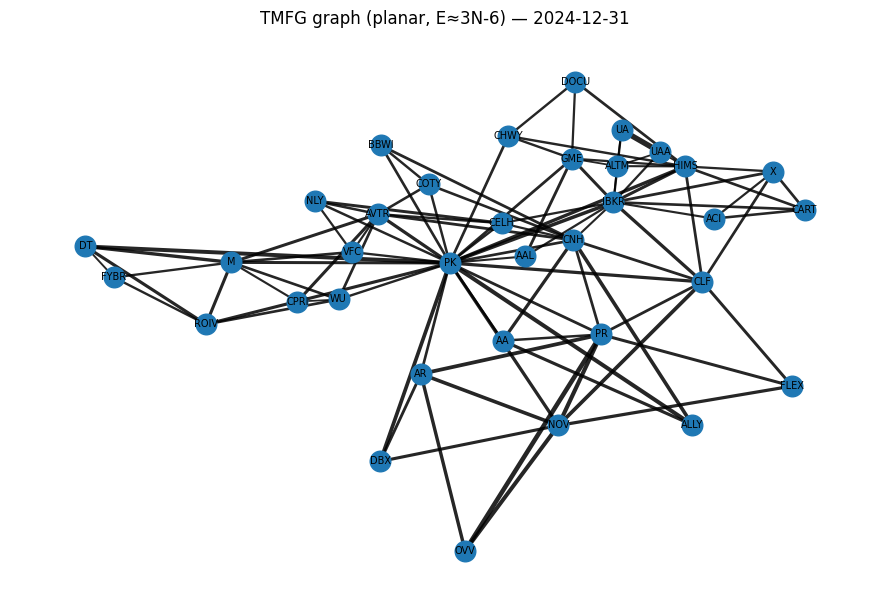

N=35 | MST edges=34 (target N-1=34) | TMFG edges=99 (target 3N-6=99)


In [ ]:
# import your graph helpers
sys.path.append("src")
from src.graph import corr_from_returns, edges_from_corr

# returns: do NOT forward-fill missing prices (avoids inventing zero-returns)
returns = (
    prices.replace(0, np.nan)
          .pct_change(fill_method=None)
          .replace([np.inf, -np.inf], np.nan)
)

# --- pick a month-end t and lookback
# last trading day per month, sorted (uses positional iloc to avoid deprecation)
rebalance_dates = (
    prices.index.to_series()
    .groupby(prices.index.to_period("M"))
    .max()
    .sort_values()
)
t = rebalance_dates.iloc[-1]    # latest month-end (or pick any with iloc[k])
lookback = 60

# --- get active tickers at t from membership
PATH_MEMBERSHIP = "data/processed/universe_membership_clean.csv"  # adjust if different
mem = pd.read_csv(PATH_MEMBERSHIP, parse_dates=["start", "end"])
mem["end"] = mem["end"].fillna(prices.index.max())
mem["ticker"] = mem["ticker"].astype(str).str.upper().str.strip()

# map membership tickers -> actual price column names (case/spacing normalisation)
col_map = {c.upper().strip(): c for c in prices.columns}
active_members = set(mem.loc[(mem["start"] <= t) & (mem["end"] >= t), "ticker"].unique())
active_cols = [col_map[s] for s in active_members if s in col_map]

# --- build the window and filter
# take the last `lookback` returns strictly BEFORE t
win_all = returns.loc[:t].iloc[:-1].tail(lookback)

is_full = win_all.notna().all(axis=0)               # fully observed in window
is_active = win_all.columns.isin(active_cols)       # in active membership at t
cols_ok = win_all.columns[is_full & is_active]

if len(cols_ok) < 5:
    raise ValueError(f"Too few assets after filtering at {t.date()} (got {len(cols_ok)}).")

# pick a compact subset to plot (top-35 by median volume in the window, else by stdev)
try:
    vol_win = volume.loc[win_all.index, cols_ok]
    subset = (
        vol_win.median()
        .sort_values(ascending=False)
        .head(min(35, len(cols_ok)))
        .index
        .tolist()
    )
except Exception:
    # fall back to most volatile names if `volume` is unavailable/misaligned
    subset = (
        win_all[cols_ok].std()
        .sort_values(ascending=False)
        .head(min(35, len(cols_ok)))
        .index
        .tolist()
    )

W = win_all[subset]               # (T x n) returns window
C = corr_from_returns(W)          # robust correlation via your helpers
tickers = subset                  # preserve plotting order

def _unique_undirected_count(ei_np: np.ndarray) -> int:
    """Count unique undirected edges given a (2, m) edge-index array."""
    if ei_np is None or ei_np.size == 0:
        return 0
    return len({tuple(sorted((int(u), int(v)))) for u, v in ei_np.T})

def plot_graph(ei_np, eattr_np, title: str, fname: str) -> None:
    """Plot a simple weighted graph; edge width ∝ |corr|."""
    n = len(tickers)
    G = nx.Graph()
    G.add_nodes_from(range(n))

    edgelist = []
    widths = []

    if ei_np is not None and ei_np.size:
        # Build unique undirected edges and attach weights by |corr|
        seen = {}
        for u, v in ei_np.T:
            u = int(u); v = int(v)
            a, b = (u, v) if u < v else (v, u)
            if (a, b) not in seen:
                strength = float(abs(C[a, b]))  # fallback: magnitude of correlation
                seen[(a, b)] = strength

        for (a, b), s in seen.items():
            G.add_edge(a, b, weight=s)
            edgelist.append((a, b))
            widths.append(1.0 + 6.0 * s)

    pos = nx.kamada_kawai_layout(G, weight="weight") if G.number_of_edges() else nx.spring_layout(G, seed=7)

    plt.figure(figsize=(9, 6.2))
    nx.draw_networkx_nodes(G, pos, node_size=220)
    if edgelist:
        nx.draw_networkx_edges(G, pos, edgelist=edgelist, width=widths, alpha=0.85)
    nx.draw_networkx_labels(G, pos, labels={i: t for i, t in enumerate(tickers)}, font_size=7)
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(OUT / fname, dpi=180)
    plt.show()

# k-NN (mutual |rho|, k=5)
ei_knn, ea_knn = edges_from_corr(
    C, method="knn", undirected=True, include_strength=True, include_sign=True, knn_k=5
)
plot_graph(ei_knn, ea_knn, f"k-NN graph (k=5) — {t.date()}", "fig_knn_k5.png")

# MST
ei_mst, ea_mst = edges_from_corr(
    C, method="mst", undirected=True, include_strength=True, include_sign=True, mst_use_abs=True
)
plot_graph(ei_mst, ea_mst, f"MST graph (E=N-1) — {t.date()}", "fig_mst.png")

# TMFG
ei_tmfg, ea_tmfg = edges_from_corr(
    C, method="tmfg", undirected=True, include_strength=True, include_sign=True, tmfg_keep_n="auto"
)
plot_graph(ei_tmfg, ea_tmfg, f"TMFG graph (planar, E≈3N-6) — {t.date()}", "fig_tmfg.png")

# precise edge counts (unique undirected)
n = len(tickers)
mst_e = _unique_undirected_count(ei_mst)
tmfg_e = _unique_undirected_count(ei_tmfg)
print(
    f"N={n} | MST edges={mst_e} (target N-1={max(0, n-1)}) | "
    f"TMFG edges={tmfg_e} (target 3N-6={max(0, 3*n-6)})"
)